# 시대별 여성복 분류 서비스

In [1]:
%config ZMQInteractiveShell.buffer_size = 99999999999999999

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## 데이터 불러오기

In [3]:
train_X=np.load('./train_X.npy')
test_X=np.load('./test_X.npy')
train_y=np.load('./train_y.npy')
test_y=np.load('./test_y.npy')
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((12000, 400, 300, 3), (4000, 400, 300, 3), (12000,), (4000,))

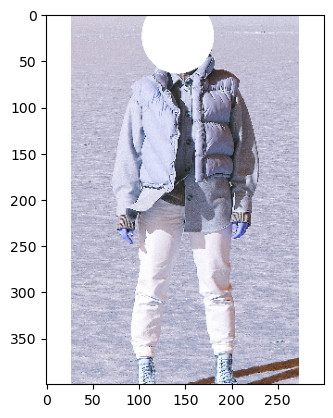

In [4]:
# 시각화 확인
idx=200
plt.imshow((train_X[idx]*255).astype('uint8'))
plt.show()

## 원핫인코딩

In [5]:
train_y=pd.get_dummies(train_y, dtype=int)
test_y=pd.get_dummies(test_y, dtype=int)
train_y.head()

,1950,1960,1970,1980,1990,2000,2010,2019
0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0


## 모델링

In [6]:
# 모델 설계 - CNN
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten

model=Sequential()
model.add(Conv2D(128, 3, input_shape=(400,300,3), activation='relu'))
model.add(MaxPool2D()) 
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 298, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 149, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 147, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 71, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 35, 32)       0

In [7]:
# 모델 생성
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [8]:
import os
model_path='./models/'

# 폴더 생성 함수
def file_check(file_path):  
    import os
    if os.path.exists(file_path) : 
        print(f"[{file_path}] 파일이 존재합니다.")
    else :
        print(f"[{file_path}] 파일이 존재하지 않습니다. \n저장 폴더를 생성합니다.")
        os.makedirs(file_path)
        print('저장 폴더 생성 완료')

file_check(model_path)

[./models/] 파일이 존재합니다.


In [9]:
# 객체 생성
model_file=model_path+'fashion_year_final.HDF5'

# callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

# 가장 좋은 모델만 저장 
mc_CB=ModelCheckpoint(monitor='val_accuracy', filepath=model_file, save_best_only=True) 

# 조기종료 설정
es_CB=EarlyStopping(patience=5)

# epoch 마다 학습률 제어
def scheduler(epoch, lr):
    if epoch>5:
        return 0.0001
    else:
        return lr
lr_CB=LearningRateScheduler(scheduler)

In [10]:
# 학습에 사용될 값 설정
EPOCHS=100
BATCH_SIZE=32
VAL_SPLIT=0.2

rst=model.fit(train_X, train_y, 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_split=VAL_SPLIT,
          callbacks=[mc_CB, es_CB, lr_CB])
rst

Epoch 1/100
168/300 [===============>..............] - ETA: 8:47 - loss: 2.0644 - accuracy: 0.1615

KeyboardInterrupt: 